In [ ]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from procurement_lib import redash
from analysts_tools.redash_methods import *

import random
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
import statsmodels.formula.api as smf

In [49]:
city = 'BAQ'
card_ids = [400643,236916,74166,135082,426463,-201695,225380]
#year-month-day
todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
#non_buyers_date = '2022-08-26' #1 months
customer_date_desde_query = (datetime.datetime.today() - datetime.timedelta(days=30)).strftime('%Y-%m-%d') #1 months

customer_date_desde = (datetime.datetime.today() - datetime.timedelta(days=200))#.strftime('%Y-%m-%d') #1 months

In [50]:
clear_buyers = get_fresh_query_result("https://internal-redash.federate.frubana.com/",138674,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [51]:
frida_products = get_fresh_query_result("https://internal-redash.federate.frubana.com/",118629,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [52]:
query ="""
with

sales as(
    select
        s.dim_submitted_date,
        su.card_id,
        case when su.source_parent_id = 0 then su.source_id else su.source_parent_id end as parent_id,
        sum((s.product_price * s.product_quantity_x_step_unit)+s.product_tax_iva) / nullif(sum(s.product_quantity_x_step_unit),0) as gross_price,
        sum((s.product_price_discount * s.product_quantity_x_step_unit)+s.product_tax_iva) / nullif(sum(s.product_quantity_x_step_unit),0) as net_price
    from dpr_sales.fact_sales s
        left join dpr_shared.dim_site site
            on s.dim_site = site.site_id
        left join dpr_shared.dim_date submit_date
            on s.dim_submitted_date = submit_date.date_id
        left join dpr_shared.dim_stock_unit su
            on s.dim_product = su.product_id
    where submit_date.full_date BETWEEN '2022-01-01' AND DATE(CURRENT_DATE)
        and s.dim_status = 1
        and site.identifier_value = '{city}'
    group by 1,2,3
)

select
    site.identifier_value as region_code,
    benchmark_day.full_date as benchmark_day,
    s.card_id,
    bc.price as benchmark_price
from dpr_pricing.snap_daily_benchmark_competitor bc
    left join dpr_shared.dim_site site
        on bc.dim_site = site.site_id
    left join dpr_shared.dim_date benchmark_day
        on bc.dim_benchmark_day = benchmark_day.date_id
    left join dpr_shared.dim_stock_unit su
        on bc.dim_stock_unit = su.stock_unit_id
    left join dpr_pricing.dim_competitor c
        on bc.dim_competitor = c.competitor_id
    left join sales s
        on s.dim_submitted_date = bc.dim_benchmark_day
        and s.parent_id = su.source_id
        and s.card_id = su.card_id
where benchmark_day.full_date BETWEEN '2022-01-01' AND DATE(CURRENT_DATE)
    and su.source_parent_id = 0
    and su.product_id != 0
    and site.identifier_value = '{city}'
order by benchmark_day desc
""".format(city=city)

df_bench = read_connection_data_warehouse.run_read_dwd_query(query)
df_bench['benchmark_day'] = pd.to_datetime(df_bench['benchmark_day']) 

df_bench.dropna(inplace=True)

In [53]:
# Group the benchmark data by product
grouped_bench = df_bench.groupby('card_id')

# Define a function to remove outliers based on the IQR method
def remove_outliers(df):
    Q1 = df['benchmark_price'].quantile(0.25)
    Q3 = df['benchmark_price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return df[(df['benchmark_price'] > lower_bound) & (df['benchmark_price'] < upper_bound)]

# Apply the remove_outliers function to each group and concatenate the results
df_bench_clean = pd.concat([remove_outliers(group) for name, group in grouped_bench])
df_bench = df_bench_clean.reset_index(drop=True).copy()

In [54]:
query = """
-- 93058
-- Se toma como base el query 2718
WITH 
ful AS (

SELECT DISTINCT
    bo.order_id,
    bo.submit_date
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_group" bfg        ON bfg.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_order" bfo        ON bfo.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_fulfillment_group" ffg         ON ffg.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order" fo                      ON fo.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_payment" bop            ON bop.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site" s                       ON s.site_id = bo.site_disc
LEFT JOIN  postgres_broadleaf_federate."broadleaf.fb_order_type" fot                ON fot.fb_order_type_id=fo.fb_order_type_id

WHERE fo.fb_order_status_id IN (1,6,7,8)
    AND extract(year from bo.submit_date::date) > 2021
    --AND extract(month from bo.submit_date::date) = 6--2021
    AND bo.order_status = 'SUBMITTED'
    AND bfo.status NOT IN ('ARCHIVED','CANCELLED')
    AND bop.archived = 'N'
    AND (fot.name IS NULL OR fot.name <> 'REFUND')
    AND s.site_identifier_value = '{city}' --NOT IN ('MTY','PBC','GDL')
    AND bo.customer_id IN {clientes}
)--,

--more AS (
SELECT DISTINCT
    s.site_identifier_value AS city,
    bo.customer_id,
    DATE(bo.submit_date) AS submit_date,
    bs.addl_product_id AS card_id,
    bs2.name,
    AVG(boi.sale_price) AS price,
    COALESCE(AVG(boida.adjustment_value),0) AS precio_dct,
    COALESCE((AVG(boi.sale_price) - AVG(boida.adjustment_value)),AVG(boi.sale_price)) AS final_price,
    SUM(boipd.quantity*foi.step_unit) AS demand

FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"      boipd   ON boipd.order_item_id=boi.order_item_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"        boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    --AND bcat2.name NOT IN ('Frutas & Verduras')
GROUP BY 1,2,3,4,5
""".format(clientes=tuple(set(clear_buyers[clear_buyers.registered_city == city].customer_id.unique())), city = city)

data_ventas_aux = read_connection_data_warehouse.runQuery(query)
data_ventas_aux[["price", "precio_dct","final_price","demand"]] = data_ventas_aux[["price", "precio_dct","final_price","demand"]].astype('float32')
data_ventas_aux['submit_date'] = pd.to_datetime(data_ventas_aux['submit_date']) 

data_ventas_aux = data_ventas_aux.loc[(data_ventas_aux.demand > 0) & (data_ventas_aux.price > 0)]

In [55]:
data_ventas_aux

,city,customer_id,submit_date,card_id,name,price,precio_dct,final_price,demand
0,CMX,52254510,2022-02-07,-201570,Papa Amarilla,13.770000,2.75,11.020000,10.0
1,CMX,73935306,2022-01-26,-201666,Leche Entera Nutrileche x 1 lt,18.299999,2.20,16.100000,1.0
2,CMX,18984556,2022-03-31,100659,Queso Panela Quinta Azul de 1 Kg,96.230003,11.55,84.680000,20.0
3,CMX,15546374,2022-03-16,-201530,Manzana Roja Nacional,41.080002,4.11,36.970001,1.0
4,CMX,68819257,2022-03-15,-201710,Huevos Blancos Medianos,418.779999,33.50,385.279999,1.0
...,...,...,...,...,...,...,...,...,...
4580443,CMX,113128646,2023-02-01,-201479,Chile de Árbol Fresco,101.269997,0.00,101.269997,0.3
4580444,CMX,15827719,2022-11-11,290910,Vaso Térmico No. 12 Dart x 25 und,15.400000,0.00,15.400000,5.0
4580445,CMX,18391937,2023-01-10,131679,Plátano Macho Maduro,21.639999,0.00,21.639999,1.0
4580446,CMX,55346765,2023-02-13,52154,Vaso térmico No. 16 Dart x 20 und,18.100000,0.00,18.100000,20.0


In [56]:
df = pd.merge(data_ventas_aux.loc[data_ventas_aux.card_id.isin(card_ids)], df_bench,  how='left', left_on=['card_id','submit_date'], right_on = ['card_id','benchmark_day'])
df.dropna(inplace=True)

In [57]:
df['net_PI'] = df.final_price / df.benchmark_price

In [58]:
# Group the benchmark data by product
grouped_data = df.groupby('card_id')

# Define a function to remove outliers based on the IQR method
def remove_outliers(df):
    Q1 = df['net_PI'].quantile(0.25)
    Q3 = df['net_PI'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return df[(df['net_PI'] > lower_bound) & (df['net_PI'] < upper_bound)]

# Apply the remove_outliers function to each group and concatenate the results
df_data_clean = pd.concat([remove_outliers(group) for name, group in grouped_data])
df = df_data_clean.reset_index(drop=True).copy()

In [59]:
df = df.groupby(['customer_id', 'card_id']).filter(lambda x: len(x) > 1)

In [60]:
# Define a function to calculate the weighted average of a column
def weighted_avg(x, df):
    return (x * df['demand']).sum() / df['demand'].sum()

# Set the index to submit_date
#df2.set_index('submit_date', inplace=True)
df['order_month'] = df['submit_date'].dt.to_period('M')


# Group the data by city, customer_id, name, and month
df_monthly = df.groupby(['city', 'customer_id', 'card_id', 'name', 'order_month']).agg({
    #'price': lambda x: weighted_avg(x, df.loc[x.index]),
    #'precio_dct': lambda x: weighted_avg(x, df.loc[x.index]),
    #'final_price': lambda x: weighted_avg(x, df2.loc[x.index]),
    #'benchmark_price': lambda x: weighted_avg(x, df.loc[x.index]),
    'net_PI': lambda x: weighted_avg(x, df.loc[x.index]),
    'demand': 'sum'
}).reset_index()

In [61]:
df_monthly = df_monthly.groupby(['customer_id', 'card_id']).filter(lambda x: len(x) > 1)

In [62]:
# Group the data by customer and product
grouped = df_monthly.groupby(['customer_id', 'card_id','name'])

# Define the regression formula
formula = 'demand ~ net_PI'

# Initialize an empty DataFrame to store the results
elasticities = pd.DataFrame(columns=['customer_id', 'card_id', 'name', 'elasticity'])

# Loop through each group and fit a regression model
for group_name, group_data in grouped:
    # Check if there are multiple points
    if len(group_data) > 1:
        # Fit the regression model
        model = smf.ols(formula=formula, data=group_data).fit()
        # Calculate the elasticity of demand
        elasticity = -model.params['net_PI'] * group_data['net_PI'].mean() / group_data['demand'].mean()
    else:
        # Use the simple formula to calculate elasticity
        elasticity = group_data['net_PI'].iloc[0] / group_data['demand'].iloc[0]
    # Append the result to the DataFrame
    elasticities = elasticities.append({'customer_id': group_name[0], 'card_id': group_name[1], 'name': group_name[2], 'elasticity': elasticity}, ignore_index=True)


In [63]:
elasticities.head()

,customer_id,card_id,name,elasticity
0,-269919,426463,Crema Ácida Lala x 900 ml,-1.584152e+01
1,-269908,225380,Papel Higiénico Kovu 6 und x 600 Hojas,2.861290e+00
2,-269885,225380,Papel Higiénico Kovu 6 und x 600 Hojas,1.881262e+00
3,-269871,135082,Boneless Pimienta y Limón Bachoco x 2.4 kg,-1.242633e-15
4,-269745,-201695,Servilleta Tradicional Marli x 450 und,4.283121e-15


In [64]:
df_aux = df.copy()
df = df_monthly.copy()

In [65]:
df.head()

,city,customer_id,card_id,name,order_month,net_PI,demand
0,CMX,-269919,426463,Crema Ácida Lala x 900 ml,2022-10,0.925000,2.0
1,CMX,-269919,426463,Crema Ácida Lala x 900 ml,2023-02,0.886875,1.0
2,CMX,-269908,225380,Papel Higiénico Kovu 6 und x 600 Hojas,2022-02,0.859155,3.0
3,CMX,-269908,225380,Papel Higiénico Kovu 6 und x 600 Hojas,2022-03,0.699006,4.0
4,CMX,-269908,225380,Papel Higiénico Kovu 6 und x 600 Hojas,2022-04,0.698182,6.0


# Aca debo empezar el experimento

In [66]:
clear_buyers[(clear_buyers.recency_days <= 20) & (clear_buyers.registered_city == city)].customer_id.nunique()

10272

In [67]:
# elasticities[(elasticities.name == sku) & 
#              (elasticities.elasticity > -1) & 
#              (elasticities.elasticity < 1) &
#              (elasticities.customer_id.isin(clear_buyers[(clear_buyers.recency_days <= 20) & (clear_buyers.registered_city == city)].customer_id.unique())) 
#              ].customer_id.nunique()

In [68]:
elasticities[(elasticities.name == sku) & 
             (elasticities.elasticity > 1) & 
             #(elasticities.elasticity < 1) &
             (elasticities.customer_id.isin(clear_buyers[(clear_buyers.recency_days <= 20) & (clear_buyers.registered_city == city)].customer_id.unique())) 
             ].customer_id.nunique()

0

In [69]:
offers = data_ventas_aux.loc[(data_ventas_aux.submit_date > datetime.datetime.today() + datetime.timedelta(days=(-21))) &
                            (data_ventas_aux.card_id.isin(card_ids))].copy()

In [70]:
offers['gmv_usd'] = offers.price * offers.demand

In [71]:
offers.head()

,city,customer_id,submit_date,card_id,name,price,precio_dct,final_price,demand,gmv_usd
402,CMX,283820669,2023-05-25,426463,Crema Ácida Lala x 900 ml,61.119999,1.22,59.900002,1.0,61.119999
2060,CMX,50443422,2023-05-19,225380,Papel Higiénico Kovu 6 und x 600 Hojas,55.900002,2.24,53.660000,1.0,55.900002
3613,CMX,198743836,2023-05-21,-201695,Servilleta Tradicional Marli x 450 und,34.660000,1.04,33.619999,1.0,34.660000
7501,CMX,63336547,2023-05-28,225380,Papel Higiénico Kovu 6 und x 600 Hojas,55.590000,2.22,53.369999,3.0,166.770004
13522,CMX,-257809,2023-05-21,225380,Papel Higiénico Kovu 6 und x 600 Hojas,54.779999,2.19,52.590000,3.0,164.339996


In [72]:
skus = [sku+'_INELASTIC',sku+'_ELASTIC']

In [77]:
from sklearn.model_selection import train_test_split 

def create_groups(offer):
    # if offer == sku+'_INELASTIC':
    #     customers = elasticities[(elasticities.name == sku) & 
    #          (elasticities.elasticity > -1) & 
    #          (elasticities.elasticity < 1) &
    #          (elasticities.customer_id.isin(clear_buyers[(clear_buyers.recency_days <= 20) & (clear_buyers.registered_city == city)].customer_id.unique())) 
    #          ].customer_id.unique()
    # else:
    
    customers = elasticities[(elasticities.name == offer) & 
            (elasticities.elasticity > 1) & 
            #(elasticities.elasticity < 1) &
            (elasticities.customer_id.isin(clear_buyers[(clear_buyers.recency_days <= 20) & (clear_buyers.registered_city == city)].customer_id.unique())) 
            ].customer_id.unique()
    
    if len(customers) == 0:
        return "Nada","Nada"
    else:
        print(len(customers))
    
    offer_df_aux = offers.loc[offers.name == offer].copy()
    
    customer_control, customer_test = train_test_split(customers, test_size = 0.50)
    alpha=0.01
    aux=0
    while abs(1-(offer_df_aux[offer_df_aux.customer_id.isin(customer_control)]['gmv_usd'].mean()/offer_df_aux[offer_df_aux.customer_id.isin(customer_test)]['gmv_usd'].mean())) > alpha:
        customer_control, customer_test = train_test_split(customers, test_size = 0.50)
        
        aux+=1
        if aux == 1000:
            alpha+=0.01
            aux=0
        
    return customer_control.tolist(), customer_test.tolist()

In [74]:
offers.loc[offers.card_id == card_ids[0],'name'].values[0]

'Queso Oaxaca Imitación Orión x 1 kg'

In [83]:
global_segment_list = [] #//for procesing
offer_name = []
cards = []
for i,card in enumerate(card_ids):
    offer = offers.loc[offers.card_id == card,'name'].values[0]
    print(offer)
    control,test = create_groups(offer)
    if control == "Nada" and test == "Nada":
        continue
    offer_name.append("SH_ELASTICITY_"+todays_date+"_"+city+"_"+offer)
    d = {'name':"SH_ELASTICITY_"+todays_date+"_"+city+"_"+offer, 'customersIds': list(test)}
    e = {'name':"SH_ELASTICITY_"+todays_date+"_"+city+"_"+offer+"_CONTROL", 'customersIds': list(control)}
    
    cards.append(card)
    global_segment_list.append(d)
    global_segment_list.append(e)

Queso Oaxaca Imitación Orión x 1 kg
Queso Gouda Zwan x 2.26 kg 
Crema Ácida Alpura x 4 lt
224
Boneless Pimienta y Limón Bachoco x 2.4 kg
26
Crema Ácida Lala x 900 ml
282
Servilleta Tradicional Marli x 450 und
162
Papel Higiénico Kovu 6 und x 600 Hojas
370


In [84]:
offer_name

['SH_ELASTICITY_2023-06-07_CMX_Crema Ácida Alpura x 4 lt',
 'SH_ELASTICITY_2023-06-07_CMX_Boneless Pimienta y Limón Bachoco x 2.4 kg',
 'SH_ELASTICITY_2023-06-07_CMX_Crema Ácida Lala x 900 ml',
 'SH_ELASTICITY_2023-06-07_CMX_Servilleta Tradicional Marli x 450 und',
 'SH_ELASTICITY_2023-06-07_CMX_Papel Higiénico Kovu 6 und x 600 Hojas']

## ADD DISCOUNT

In [85]:
dct = [5,3,4,5.5,7.5]

In [86]:
csv_file = {} 
csv_file['offer_name'] = offer_name
csv_file['offer_description'] = None
csv_file['discount'] = dct
csv_file['automatically_consider_offer'] = "true"
csv_file['start_date'] = (datetime.datetime.today() + datetime.timedelta(0)).strftime('%d-%m-%Y')
csv_file['end_date'] = (datetime.datetime.today() + datetime.timedelta(days=(7))).strftime('%d-%m-%Y')
csv_file['max_uses_per_order'] = [0]*len(offer_name)
csv_file['max_uses_per_customer'] = [0]*len(offer_name)
csv_file['customer_segment_id'] = [1]*len(offer_name) #[None]
csv_file['sku_id'] = [frida_products.loc[frida_products.id_tarjeta == sku,"skus"].values[0] for sku in cards]
global_offer_csv = pd.DataFrame(csv_file) #, index=[0])

In [87]:
global_offer_csv

,offer_name,offer_description,discount,automatically_consider_offer,start_date,end_date,max_uses_per_order,max_uses_per_customer,customer_segment_id,sku_id
0,SH_ELASTICITY_2023-06-07_CMX_Crema Ácida Alpur...,None,5.0,true,07-06-2023,14-06-2023,0,0,1,93264
1,SH_ELASTICITY_2023-06-07_CMX_Boneless Pimienta...,None,3.0,true,07-06-2023,14-06-2023,0,0,1,167405
2,SH_ELASTICITY_2023-06-07_CMX_Crema Ácida Lala ...,None,4.0,true,07-06-2023,14-06-2023,0,0,1,594397
3,SH_ELASTICITY_2023-06-07_CMX_Servilleta Tradic...,None,5.5,true,07-06-2023,14-06-2023,0,0,1,218797#218799#-304077
4,SH_ELASTICITY_2023-06-07_CMX_Papel Higiénico K...,None,7.5,true,07-06-2023,14-06-2023,0,0,1,288939


In [88]:
import requests
import json

url = f"https://{city}.frubana.com/api/v1/segments/create?api-key=00_growth-team-zzz-qqq_001"

payload = json.dumps(global_segment_list)


headers = {
  'Cookie': 'AWSALB=WGKrKvA1CFOY0m92xSENGAseuE4LrcfQh9y8jK/loGBJdizNm+FvjOqUqVghxdfLkH6Jsa9sfWft2NELchGAP/LNZMXMYhrOE70qDnUuOHATpdJj1UZBMEUBSIN1; AWSALBCORS=WGKrKvA1CFOY0m92xSENGAseuE4LrcfQh9y8jK/loGBJdizNm+FvjOqUqVghxdfLkH6Jsa9sfWft2NELchGAP/LNZMXMYhrOE70qDnUuOHATpdJj1UZBMEUBSIN1; AWSALB=jLY02FPysvF1vTrKLhXbk3ibzmyiAqFJ1ezYVu5PjodkU2QmPHDpRJhb9CvOlOyQ1Ix0mJR1ig+eH9zwJ9i5EOtgsgx79NSROogQb2Ua6yLX/I3bJJ6xtcVO3puI; AWSALBCORS=jLY02FPysvF1vTrKLhXbk3ibzmyiAqFJ1ezYVu5PjodkU2QmPHDpRJhb9CvOlOyQ1Ix0mJR1ig+eH9zwJ9i5EOtgsgx79NSROogQb2Ua6yLX/I3bJJ6xtcVO3puI',
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

In [89]:
sgt = [(int(x[:6]),x[7:]) for x in list(map(str.strip, response.text[32:].strip('][').replace('"', '').split(',')))]

In [90]:
for i in global_offer_csv.offer_name:
    for j,z in sgt:
        if z==i:
            global_offer_csv.loc[global_offer_csv.offer_name == i, ('customer_segment_id')] = j
            break

In [91]:
global_offer_csv

,offer_name,offer_description,discount,automatically_consider_offer,start_date,end_date,max_uses_per_order,max_uses_per_customer,customer_segment_id,sku_id
0,SH_ELASTICITY_2023-06-07_CMX_Crema Ácida Alpur...,None,5.0,true,07-06-2023,14-06-2023,0,0,172659,93264
1,SH_ELASTICITY_2023-06-07_CMX_Boneless Pimienta...,None,3.0,true,07-06-2023,14-06-2023,0,0,172658,167405
2,SH_ELASTICITY_2023-06-07_CMX_Crema Ácida Lala ...,None,4.0,true,07-06-2023,14-06-2023,0,0,172655,594397
3,SH_ELASTICITY_2023-06-07_CMX_Servilleta Tradic...,None,5.5,true,07-06-2023,14-06-2023,0,0,172661,218797#218799#-304077
4,SH_ELASTICITY_2023-06-07_CMX_Papel Higiénico K...,None,7.5,true,07-06-2023,14-06-2023,0,0,172663,288939


In [92]:
#//--------------------------------------------
#//Exporting single file data
global_offer_csv.to_csv(f'ELASTICITY_{city}_{todays_date}_OFFER.csv', index = False)

# Aca son las graficas

In [30]:
elasticities.loc[(elasticities.name == sku) & 
             #(elasticities.elasticity > -1) & 
             (elasticities.elasticity > 1)].sort_values("elasticity")

,customer_id,name,elasticity
88930,66820025,Azúcar Bulto x 50kg,1.004112
145905,229116993,Azúcar Bulto x 50kg,1.010899
131697,184588720,Azúcar Bulto x 50kg,1.013224
136016,201058268,Azúcar Bulto x 50kg,1.016189
63805,47577408,Azúcar Bulto x 50kg,1.027390
...,...,...,...
155774,267179258,Azúcar Bulto x 50kg,3680.809990
161429,298663737,Azúcar Bulto x 50kg,17289.768433
162379,306562937,Azúcar Bulto x 50kg,22074.733032
162675,309655760,Azúcar Bulto x 50kg,58820.291597


In [39]:
elasticities.loc[(elasticities.name == sku) & 
             (elasticities.elasticity > -1) & 
             (elasticities.elasticity < 1)].sort_values("elasticity").head(20)

,customer_id,name,elasticity
70663,52071976,Azúcar Bulto x 50kg,-0.997877
79374,58608650,Azúcar Bulto x 50kg,-0.990047
1116,-252277,Azúcar Bulto x 50kg,-0.948446
127741,173054123,Azúcar Bulto x 50kg,-0.943847
98087,83657732,Azúcar Bulto x 50kg,-0.925880
125601,167601304,Azúcar Bulto x 50kg,-0.906763
109748,114039147,Azúcar Bulto x 50kg,-0.892142
94672,76332497,Azúcar Bulto x 50kg,-0.885172
96042,78526909,Azúcar Bulto x 50kg,-0.883886
146656,232077231,Azúcar Bulto x 50kg,-0.874211


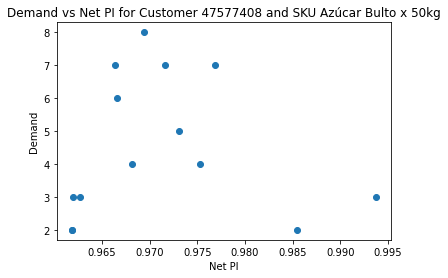

In [43]:
import matplotlib.pyplot as plt

# Filter data for a specific customer and SKU
customer_id = 47577408
#sku = 'Azúcar Bulto x 50kg'
filtered_data = df[(df['customer_id'] == customer_id) & (df['name'] == sku)]

# Create a scatterplot of demand vs net_PI
plt.scatter(filtered_data['net_PI'], filtered_data['demand'])
plt.title(f'Demand vs Net PI for Customer {customer_id} and SKU {sku}')
plt.xlabel('Net PI')
plt.ylabel('Demand')
plt.show()
# 95 110
# 90 110

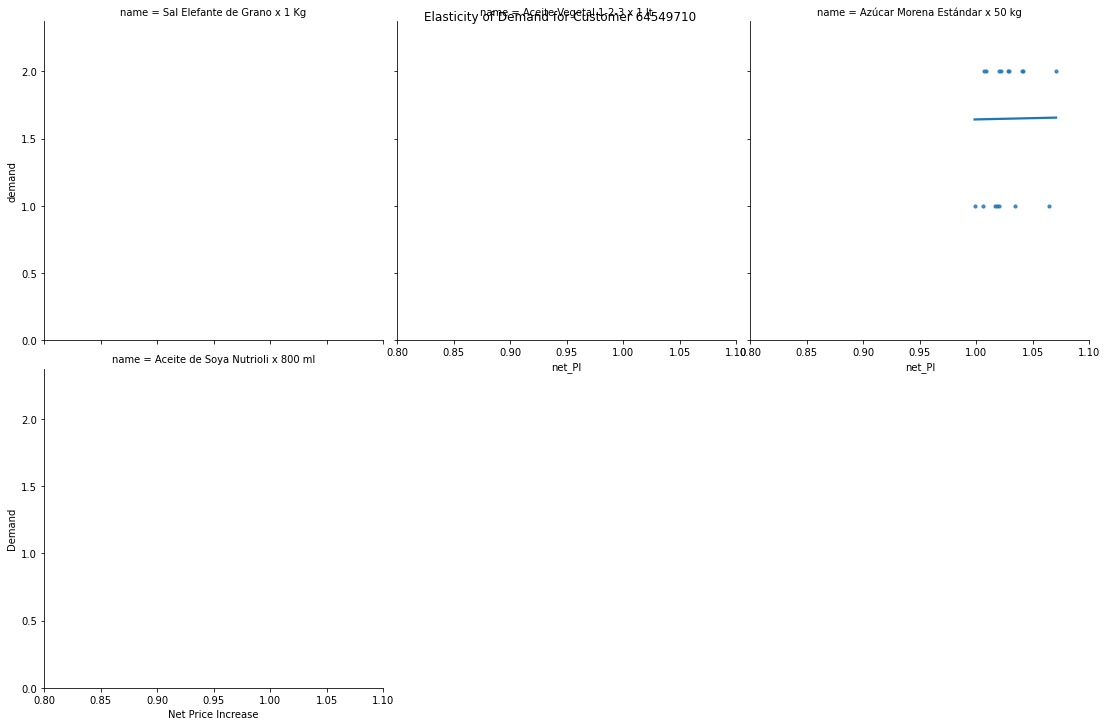

In [26]:
import seaborn as sns

# subset the data for a specific customer id
customer_id = 64549710
df_cust = df[df['customer_id'] == customer_id]

# create a scatterplot with regression line
sns.lmplot(x='net_PI', y='demand', data=df_cust, col='name', col_wrap=3, ci=None, scatter_kws={'s': 10})

# set the x and y axis labels and limits
plt.xlabel('Net Price Increase')
plt.ylabel('Demand')
plt.xlim(0.8, 1.1)
plt.ylim(0, df_cust['demand'].mean())

# set the plot title
plt.suptitle(f'Elasticity of Demand for Customer {customer_id}')

# show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Filter data for a specific customer
customer_name = -220531
customer_data = df[df['customer_id']==customer_name]

# Get unique SKUs for the customer
skus = customer_data['name'].unique()

# Set up the plot
num_plots = len(skus)
cols = 2
rows = (num_plots + 1) // 2
fig, axs = plt.subplots(rows, cols, figsize=(30,30))
axs = axs.flatten()

# Define colors
colors = plt.cm.tab20.colors

# Plot each SKU
for i, sku in enumerate(skus):
    sku_data = customer_data[customer_data['name']==sku]
    if len(sku_data) <= 1:
        print(f'{sku} has only been purchased once')
    else:
        color = colors[i % len(colors)]
        axs[i].scatter(sku_data['net_PI'], sku_data['demand'], s=50, color=color)
        axs[i].set_xlabel('Net PI')
        axs[i].set_ylabel('Demand')
        axs[i].set_title(sku)

        # Calculate the linear regression coefficients
        x = sku_data['net_PI']
        y = sku_data['demand']
        slope, intercept = np.polyfit(x, y, 1)

        # Plot the trend line
        trend_line_x = np.array([x.min(), x.max()])
        trend_line_y = slope * trend_line_x + intercept
        axs[i].plot(trend_line_x, trend_line_y, color='black', linewidth=2)

# Remove empty subplots
for j in range(num_plots, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_demand_vs_netPI(df, customer_id, sku):
    # Filter the dataframe for the given customer_id and sku
    filtered_df = df[(df['customer_id'] == customer_id) & (df['name'] == sku)]

    # Check if the filtered dataframe is not empty
    if not filtered_df.empty:
        # Create the plot
        fig, ax = plt.subplots()
        ax.scatter(filtered_df['net_PI'], filtered_df['demand'], s=10, alpha=0.5, color='blue')

        # Set axis labels and title
        ax.set_xlabel('Net PI')
        ax.set_ylabel('Demand')
        ax.set_title(f'Demand vs Net PI for customer {customer_id} and SKU {sku}')

        # Adjust plot layout
        fig.tight_layout()

        # Show or save the plot
        plt.show()
    else:
        print(f"No data found for customer {customer_id} and SKU {sku}")

In [ ]:
customer_ids=[-258834]
for customer_id in customer_ids:
    # Get the unique skus for this customer
    customer_skus = df[df['customer_id'] == customer_id]['name'].unique()

    for sku in customer_skus:
        plot_demand_vs_netPI(df, customer_id, sku)
